In [1]:
%matplotlib inline
import pandas as pd
import sys
import numpy as np
import datetime
import seaborn as sns


In [2]:
#import ML models

from sklearn.preprocessing import StandardScaler
from sklearn import cross_validation
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.pipeline import Pipeline
from sklearn.grid_search import GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier


In [3]:
from IPython.core.display import HTML
css = open('../Data/style-table.css').read() + open('../Data/style-notebook.css').read()
HTML('<style>{}</style>'.format(css))

In [4]:
#imports the raw data in chunks. SQL export could not accomodate one CSV dump

USMTO1 = pd.DataFrame.from_csv('../Data/USMTO1.norm.csv', index_col = False)
USMTO2 = pd.DataFrame.from_csv('../Data/USMTO2.norm.csv', index_col = False)
USMTO3 = pd.DataFrame.from_csv('../Data/USMTO3.norm.csv', index_col = False)
USMTO4 = pd.DataFrame.from_csv('../Data/USMTO4.norm.csv', index_col = False)
USMTO5 = pd.DataFrame.from_csv('../Data/USMTO5.norm.csv', index_col = False)

In [5]:
#imports raw data for S&P 500 values and Industrial Production

SP_500 = pd.DataFrame.from_csv('../Data/SP_500.csv', index_col = False)

In [6]:
#re-combines raw data

USMTO_WHOLE = USMTO1.append(USMTO2).append(USMTO3).append(USMTO4).append(USMTO5)

In [7]:
#merges external data with USMTO data

USMTO_WHOLE = USMTO_WHOLE.merge(SP_500, how='inner', on = ['EntryMonth', 'EntryYear'])

In [8]:
#format order date to datetime to prepare for analysis

USMTO_WHOLE['OrderDateFormatted'] = pd.to_datetime(USMTO_WHOLE.OrderDate)

In [9]:
#format changed date to datetime to prepare for analysis

USMTO_WHOLE['ChangedDateFormatted'] = pd.to_datetime(USMTO_WHOLE.ChangedDate)

In [10]:
#format submit date to datetime to prepare for analysis

USMTO_WHOLE['SubmitDateFormatted'] = pd.to_datetime(USMTO_WHOLE.SubmitDate.fillna(''))

In [11]:
#more formatting to get Order Date at End of Month

USMTO_WHOLE['hyphen'] = "-"

USMTO_WHOLE['OrderDateEOM'] = (USMTO_WHOLE.EntryYear.astype(str)) + (USMTO_WHOLE.hyphen) + (USMTO_WHOLE.EntryMonth.astype(str)) + (USMTO_WHOLE.hyphen) + (USMTO_WHOLE.OrderDateFormatted.dt.days_in_month.astype(str))

In [12]:
#format OrderDateEOM to datetime

USMTO_WHOLE['OrderDateEOM'] = pd.to_datetime(USMTO_WHOLE['OrderDateEOM'])


In [13]:
#create column DaysLate which indicates how many days late the order was submitted

USMTO_WHOLE['DaysLate'] = (USMTO_WHOLE['SubmitDateFormatted'] - USMTO_WHOLE['OrderDateEOM']).dt.days - 10

In [14]:
#fill all NaN with "0" -> count=141

USMTO_WHOLE['DaysLate'] = USMTO_WHOLE['DaysLate'].fillna('0')

In [15]:
#cast DaysLate and TotalSale as float64

USMTO_WHOLE['DaysLate'] = pd.to_numeric(USMTO_WHOLE['DaysLate'])
USMTO_WHOLE['TotalSale'] = (USMTO_WHOLE['TotalSale'].replace( '[\$,)]','', regex=True )
               .replace( '[(]','-',   regex=True ).astype(float))

In [16]:
#drop un-needed columns

USMTO_WHOLE = USMTO_WHOLE.drop('SubmitDate', axis=1)
USMTO_WHOLE = USMTO_WHOLE.drop('OrderDate', axis=1)
USMTO_WHOLE = USMTO_WHOLE.drop('ChangedDate', axis=1)
USMTO_WHOLE = USMTO_WHOLE.drop('IsCancel', axis=1)
USMTO_WHOLE = USMTO_WHOLE.drop('CancelOrderID', axis=1)
USMTO_WHOLE = USMTO_WHOLE.drop('hyphen', axis=1)
USMTO_WHOLE = USMTO_WHOLE.drop('IsMatch', axis=1)
USMTO_WHOLE = USMTO_WHOLE.drop('IsIgnore', axis=1)


In [4]:
#creates columns IsEmailOne, IsEmailTwo, IsCall indicating when reminders are made for a member to submit

USMTO_WHOLE['IsEmailOne'] = USMTO_WHOLE['DaysLate'] >= 1
USMTO_WHOLE.IsEmailOne = USMTO_WHOLE.IsEmailOne.astype('int')       

USMTO_WHOLE['IsEmailTwo'] = USMTO_WHOLE['DaysLate'] >= 5
USMTO_WHOLE.IsEmailTwo = USMTO_WHOLE.IsEmailTwo.astype('int')    

USMTO_WHOLE['IsCall'] = USMTO_WHOLE['DaysLate'] >= 10
USMTO_WHOLE.IsCall = USMTO_WHOLE.IsCall.astype('int')

USMTO_WHOLE['IsBackfill'] = USMTO_WHOLE['DaysLate'] >= 90
USMTO_WHOLE.IsBackfill = USMTO_WHOLE.IsBackfill.astype('int')

USMTO_WHOLE.to_csv('../Data/Intermediate.csv')

#caches the data

NameError: name 'USMTO_WHOLE' is not defined

In [4]:
#import from cache to save time

USMTO_WHOLE = pd.DataFrame.from_csv('../Data/Intermediate.csv', index_col = False)

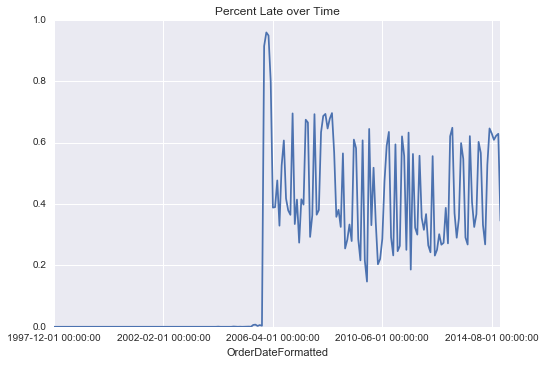

In [5]:
#shows the need to truncate data set and dump data before 2006

USMTO_WHOLE.groupby(['OrderDateFormatted'])['IsEmailOne'].mean().plot(kind = 'line', title = 'Percent Late over Time')

In [6]:
#tosses the former half of data which may not be relevant

USMTO_WHOLE = USMTO_WHOLE[(USMTO_WHOLE.OrderDateFormatted >= '2006-05-01')]

In [7]:
#shows columns of cleaned dataset

USMTO_WHOLE.columns

Index(['Unnamed: 0', 'OrderID', 'AAID', 'NAICSID', 'CustomerZipCode',
       'ShippingCountryID', 'ShippingZipCode', 'Units', 'TotalSale',
       'CreatedBy', 'CreateDate', 'ChangedBy', 'IsSubmitted',
       'TopCategoryName', 'SubCategory', 'SubCategoryName', 'Description',
       'MachineCode', 'EntryMonth', 'EntryYear', 'Date', 'Close', 'IP',
       'OrderDateFormatted', 'ChangedDateFormatted', 'SubmitDateFormatted',
       'OrderDateEOM', 'DaysLate', 'IsEmailOne', 'IsEmailTwo', 'IsCall',
       'IsBackfill'],
      dtype='object')

In [8]:
#create two new tables, one without outliers (outside 2 stdev), and one without backfillers (defined as submitted later than 100 days - per company definition)

USMTO_NO_SUBMIT_OUTLIERS = USMTO_WHOLE[np.abs(USMTO_WHOLE.DaysLate-USMTO_WHOLE.DaysLate.mean())<=(2*USMTO_WHOLE.DaysLate.std())] 
USMTO_NO_SUBMIT_BACKFILL = USMTO_WHOLE[USMTO_WHOLE.DaysLate <= 90]

#source: http://stackoverflow.com/questions/23199796/detect-and-exclude-outliers-in-pandas-dataframe


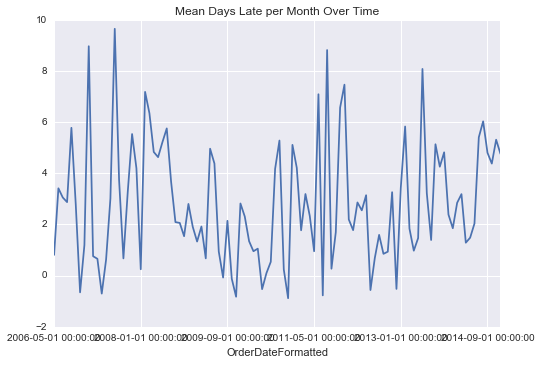

In [9]:
#Plots days late in a time series. Exhibit 1A, to be shared with team.

USMTO_NO_SUBMIT_BACKFILL.groupby(['OrderDateFormatted'])['DaysLate'].mean().plot(kind = 'line', title = 'Mean Days Late per Month Over Time')

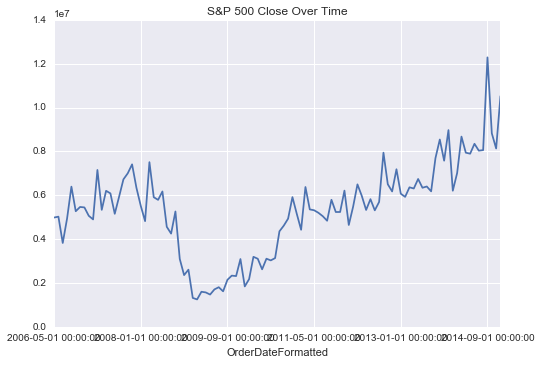

In [10]:
USMTO_WHOLE.groupby(['OrderDateFormatted'])['Close'].sum().plot(kind = 'line', title = 'S&P 500 Close Over Time')

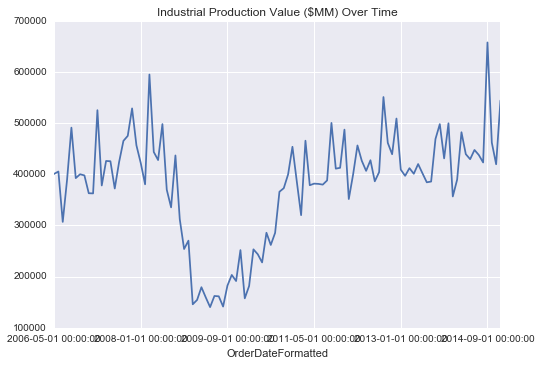

In [11]:
USMTO_WHOLE.groupby(['OrderDateFormatted'])['IP'].sum().plot(kind = 'line', title = 'Industrial Production Value ($MM) Over Time')

In [12]:
#possible causes of change in oscillation
#box and whisker plots - how distribution changed over time
#change of median, edge, etc?
#potential companies that may have joined around 2005


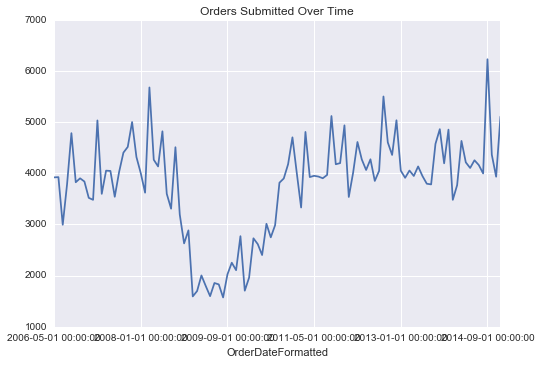

In [13]:
#plot order submission trend. Exhibit 2

USMTO_WHOLE.groupby(['OrderDateFormatted'])['IsSubmitted'].sum().plot(kind = 'line', title = 'Orders Submitted Over Time')

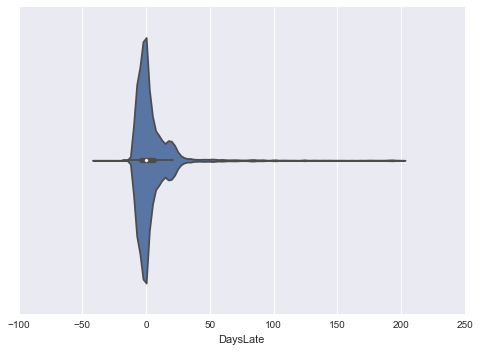

In [14]:
#plots distribution of days late - shows problem is not "endemic" but most rather participants are OK at submitting

sns.violinplot(USMTO_NO_SUBMIT_OUTLIERS.DaysLate, title = 'Distribution of Days Late, 1997 to present')


In [15]:
#Creates table that groups by AAID and OrderDateFormatted

AAID_BY_MONTH = USMTO_WHOLE.groupby(['AAID','OrderDateFormatted'])['DaysLate','TotalSale','IsEmailOne', 'IsEmailTwo', 'IsCall', 'IsBackfill','Close','IP'].mean()
AAID_BY_MONTH.reset_index(level=1, inplace=True)
AAID_BY_MONTH.reset_index(level=1, inplace=True)
AAID_BY_MONTH_2 = USMTO_WHOLE.groupby(['AAID','OrderDateFormatted'])['Units','TotalSale'].sum()
AAID_BY_MONTH_2.reset_index(level=1, inplace=True)
AAID_BY_MONTH_2.reset_index(level=1, inplace=True)
AAID_BY_MONTH = AAID_BY_MONTH.merge(AAID_BY_MONTH_2, how = 'inner', on = ['AAID','OrderDateFormatted'])
AAID_BY_MONTH['TotalSaleAvg'] = AAID_BY_MONTH['TotalSale_x']
AAID_BY_MONTH['TotalSale'] = AAID_BY_MONTH['TotalSale_y']
AAID_BY_MONTH = AAID_BY_MONTH.drop('TotalSale_x', axis = 1)
AAID_BY_MONTH = AAID_BY_MONTH.drop('TotalSale_y', axis = 1)
AAID_BY_MONTH.head()

,AAID,OrderDateFormatted,DaysLate,IsEmailOne,IsEmailTwo,IsCall,IsBackfill,Close,IP,Units,TotalSaleAvg,TotalSale
0,123,2007-12-01 00:00:00,522.0,1,1,1,1,1468.359985,105.7256,13,18461.538462,240000.0
1,123,2010-10-01 00:00:00,673.0,1,1,1,1,1183.260010,95.6362,2,100000.000000,200000.0
2,100005,2006-05-01 00:00:00,-5.0,0,0,0,0,1270.089966,102.1531,7,131438.714286,920071.0
3,100005,2006-06-01 00:00:00,1.0,1,0,0,0,1270.199951,102.5220,2,153945.500000,307891.0
4,100005,2006-07-01 00:00:00,-8.0,0,0,0,0,1276.660034,102.5057,11,57971.090909,637682.0


In [16]:
#imports tables to work on, created from CreateAAIDByMonth

AAID_BY_MONTH_NO_BACKFILL = pd.DataFrame.from_csv('../Data/result.csv', index_col = False)
AAID_BY_MONTH_NO_BACKFILL = AAID_BY_MONTH_NO_BACKFILL.fillna(value = 0)

In [17]:
#shows columns of table we are about to work with

AAID_BY_MONTH_NO_BACKFILL.columns

Index(['Unnamed: 0', 'AAID', 'OrderDateFormatted', 'DaysLate', 'IsEmailOne',
       'IsEmailTwo', 'IsCall', 'IsBackfill', 'Close', 'IP', 'Units',
       'MetalCutting', 'MetalForming', 'OtherMT', 'TotalSaleAvg', 'TotalSale',
       'UnitsLast', 'IsCallLast', 'TotalSaleAvgLast', 'TotalSaleLastThree',
       'DaysLateLastThree', 'DaysLateLast', 'MetalCuttingLast',
       'MetalFormingLast', 'OtherMTLast'],
      dtype='object')

In [18]:
#exports days late by aaid for further analysis

b = AAID_BY_MONTH_NO_BACKFILL.groupby(['AAID'])['DaysLate'].mean()
c = pd.DataFrame(b)
c.to_csv('../Data/DaysLateByAAID',sep = ',')

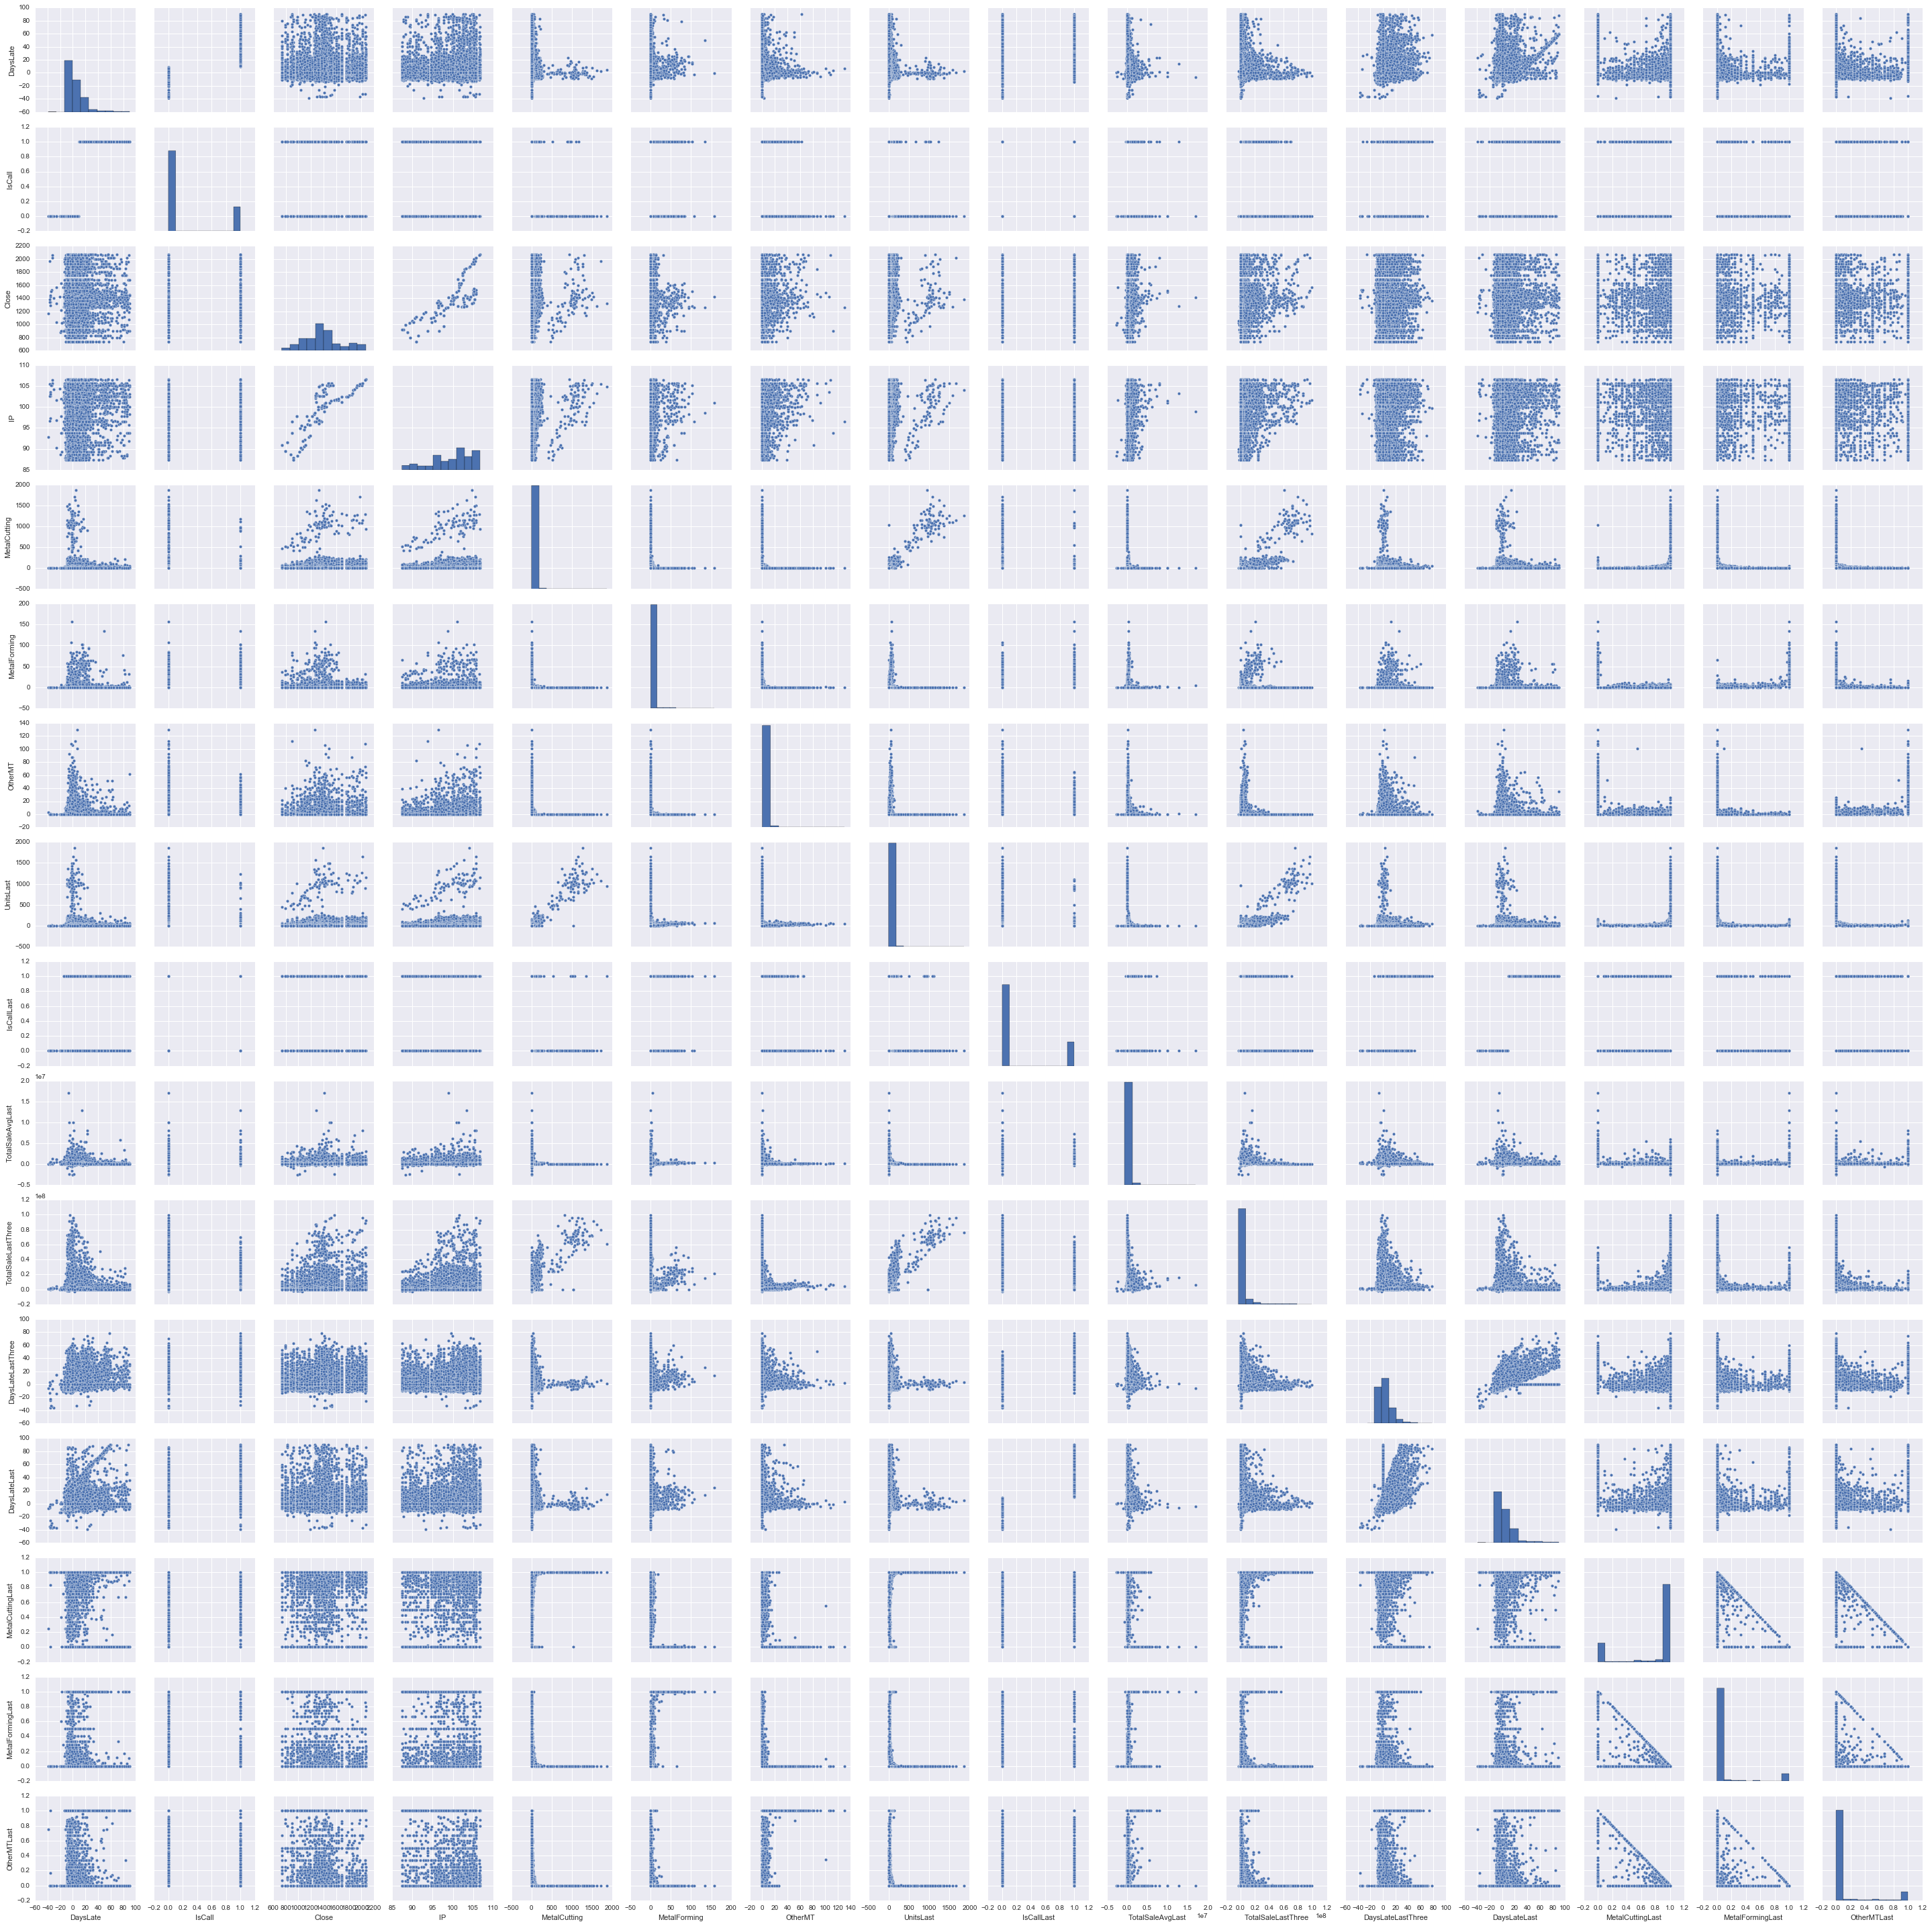

In [19]:
#scatter matrix identifying key features and their relationships - target excluded

PAIRPLOT2 = AAID_BY_MONTH_NO_BACKFILL
PAIRPLOT2 = PAIRPLOT2.drop('Unnamed: 0',axis = 1)
PAIRPLOT2 = PAIRPLOT2.drop('AAID', axis = 1)
PAIRPLOT2 = PAIRPLOT2.drop('OrderDateFormatted', axis = 1)
PAIRPLOT2 = PAIRPLOT2.drop('IsEmailOne', axis = 1)
PAIRPLOT2 = PAIRPLOT2.drop('IsEmailTwo', axis = 1)
PAIRPLOT2 = PAIRPLOT2.drop('IsBackfill', axis = 1)
PAIRPLOT2 = PAIRPLOT2.drop('TotalSaleAvg', axis = 1)
PAIRPLOT2 = PAIRPLOT2.drop('Units', axis = 1)
PAIRPLOT2 = PAIRPLOT2.drop('TotalSale', axis = 1)

sns.pairplot(PAIRPLOT2)

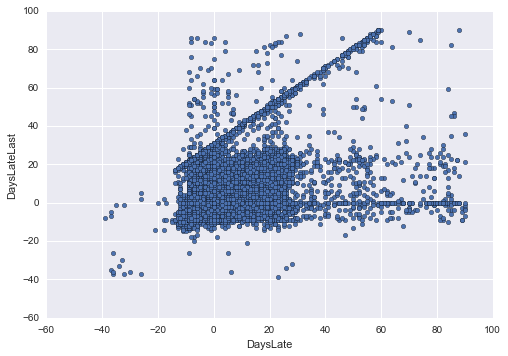

In [20]:
#DaysLate Last vs Days Late (suspicious line was investigated - business reason for this, not data error)

AAID_BY_MONTH_NO_BACKFILL.plot.scatter('DaysLate','DaysLateLast')

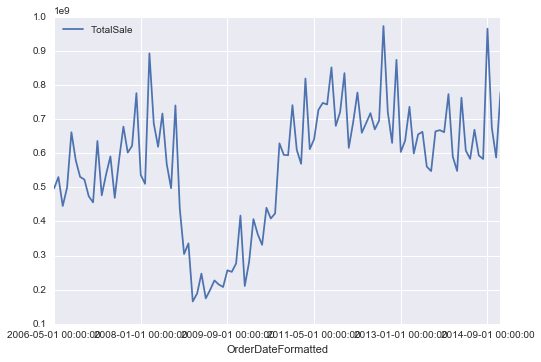

In [21]:
#average sales over time

BY_MONTH = AAID_BY_MONTH.groupby(['OrderDateFormatted']).sum()
BY_MONTH.reset_index(level=1, inplace=True)
BY_MONTH.plot(x='OrderDateFormatted', y='TotalSale')

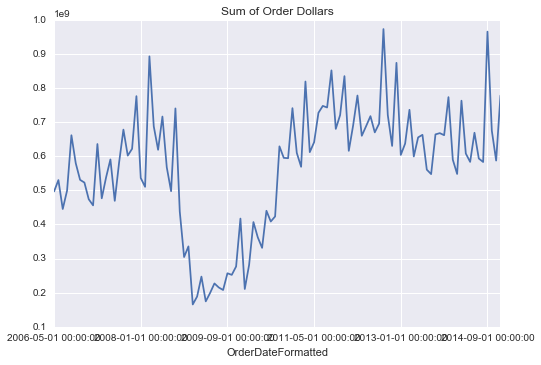

In [22]:
#plot of orders submitted over time

USMTO_WHOLE.groupby(['OrderDateFormatted'])['TotalSale'].sum().plot(kind = 'line', title = 'Sum of Order Dollars')

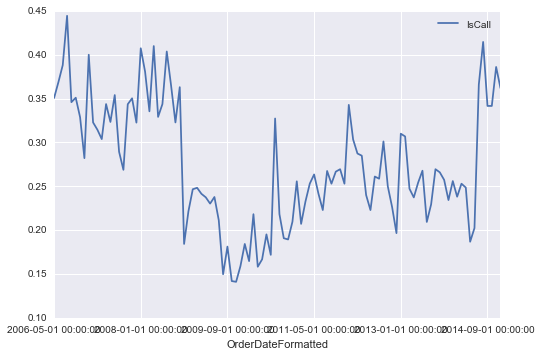

In [23]:
#percentage of company by month who needed to be called

BY_MONTH = AAID_BY_MONTH.groupby(['OrderDateFormatted']).mean()
BY_MONTH.reset_index(level=1, inplace=True)
BY_MONTH.plot(x='OrderDateFormatted', y='IsCall')

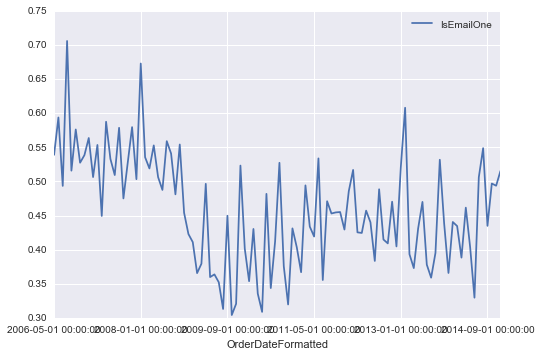

In [24]:
#percentage of company by month who needed to have first email sent

BY_MONTH = AAID_BY_MONTH.groupby(['OrderDateFormatted']).mean()
BY_MONTH.reset_index(level=1, inplace=True)
BY_MONTH.plot(x='OrderDateFormatted', y='IsEmailOne')

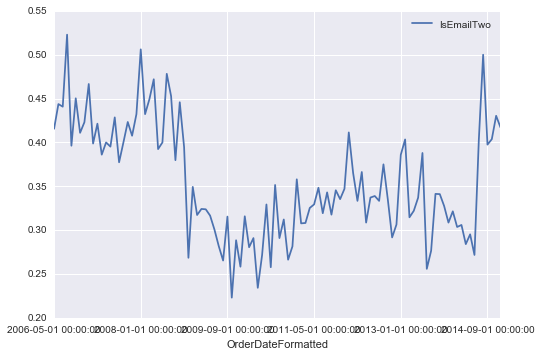

In [25]:
#percentage of company by month who needed to have second email sent

BY_MONTH = AAID_BY_MONTH.groupby(['OrderDateFormatted']).mean()
BY_MONTH.reset_index(level=1, inplace=True)
BY_MONTH.plot(x='OrderDateFormatted', y='IsEmailTwo')

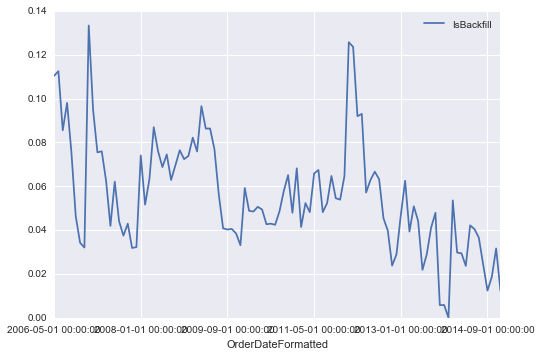

In [26]:
#percentage of company by month who backfilled

BY_MONTH = AAID_BY_MONTH.groupby(['OrderDateFormatted']).mean()
BY_MONTH.reset_index(level=1, inplace=True)
BY_MONTH.plot(x='OrderDateFormatted', y='IsBackfill')

In [27]:
#shows columns we are working with in new dataset

PAIRPLOT2.columns

Index(['DaysLate', 'IsCall', 'Close', 'IP', 'MetalCutting', 'MetalForming',
       'OtherMT', 'UnitsLast', 'IsCallLast', 'TotalSaleAvgLast',
       'TotalSaleLastThree', 'DaysLateLastThree', 'DaysLateLast',
       'MetalCuttingLast', 'MetalFormingLast', 'OtherMTLast'],
      dtype='object')

In [28]:
#prep for correlation matrix - target included. also the dataframe for machine learning algorithms

PAIRPLOT2 = AAID_BY_MONTH_NO_BACKFILL
PAIRPLOT2 = PAIRPLOT2.drop('AAID', axis = 1)
PAIRPLOT2 = PAIRPLOT2.drop('OrderDateFormatted', axis = 1)
PAIRPLOT2 = PAIRPLOT2.drop('IsEmailOne', axis = 1)
PAIRPLOT2 = PAIRPLOT2.drop('IsEmailTwo', axis = 1)
PAIRPLOT2 = PAIRPLOT2.drop('IsBackfill', axis = 1)
PAIRPLOT2 = PAIRPLOT2.drop('DaysLate', axis = 1)
PAIRPLOT2 = PAIRPLOT2.drop('TotalSaleAvg', axis = 1)
PAIRPLOT2 = PAIRPLOT2.drop('Units', axis = 1)
PAIRPLOT2 = PAIRPLOT2.drop('TotalSale', axis = 1)
PAIRPLOT2 = PAIRPLOT2.drop('DaysLateLast', axis = 1)
PAIRPLOT2 = PAIRPLOT2.drop('Unnamed: 0', axis = 1)

corr2 = PAIRPLOT2.corr(method = 'pearson')

In [29]:
#Class Distribution

AAID_BY_MONTH_NO_BACKFILL.groupby('IsCall').size()

IsCall
0    12321
1     3719
dtype: int64

In [30]:
#Skew of Attributes

PAIRPLOT2.skew()

IsCall                 1.270878
Close                  0.369165
IP                    -0.724223
MetalCutting          11.793092
MetalForming          10.854313
OtherMT                8.648067
UnitsLast             11.925780
IsCallLast             1.313808
TotalSaleAvgLast      12.234455
TotalSaleLastThree     5.966600
DaysLateLastThree      1.865813
MetalCuttingLast      -1.455438
MetalFormingLast       2.987109
OtherMTLast            2.602776
dtype: float64

In [31]:
#correlation matrix

PAIRPLOT2.corr()

,IsCall,Close,IP,MetalCutting,MetalForming,OtherMT,UnitsLast,IsCallLast,TotalSaleAvgLast,TotalSaleLastThree,DaysLateLastThree,MetalCuttingLast,MetalFormingLast,OtherMTLast
IsCall,1.000000,0.077764,0.122950,-0.031375,0.073419,-0.022075,-0.028395,0.461439,0.030896,-0.011536,0.451431,-0.037383,0.025374,-0.012420
Close,0.077764,1.000000,0.789642,0.034318,-0.021192,0.028282,0.036185,0.068478,0.028630,0.067036,0.066066,0.042227,-0.024937,-0.014672
IP,0.122950,0.789642,1.000000,0.043690,0.007734,0.030276,0.045953,0.108129,0.030492,0.076427,0.098946,0.004580,-0.014200,-0.008803
MetalCutting,-0.031375,0.034318,0.043690,1.000000,-0.038270,-0.048594,0.948883,-0.027380,-0.053511,0.752365,-0.019775,0.117586,-0.075127,-0.084317
MetalForming,0.073419,-0.021192,0.007734,-0.038270,1.000000,-0.035467,0.017808,0.071906,0.013472,0.151140,0.065773,-0.317600,0.522718,-0.054672
OtherMT,-0.022075,0.028282,0.030276,-0.048594,-0.035467,1.000000,0.002748,-0.022865,-0.034586,-0.000131,0.025036,-0.384546,-0.062087,0.577560
UnitsLast,-0.028395,0.036185,0.045953,0.948883,0.017808,0.002748,1.000000,-0.023003,-0.053644,0.779144,-0.010440,0.078116,-0.042974,-0.048749
IsCallLast,0.461439,0.068478,0.108129,-0.027380,0.071906,-0.022865,-0.023003,1.000000,0.032428,-0.003221,0.648986,0.004879,0.032034,-0.003102
TotalSaleAvgLast,0.030896,0.028630,0.030492,-0.053511,0.013472,-0.034586,-0.053644,0.032428,1.000000,0.112346,0.032234,0.007253,0.029900,-0.003128
TotalSaleLastThree,-0.011536,0.067036,0.076427,0.752365,0.151140,-0.000131,0.779144,-0.003221,0.112346,1.000000,0.018902,0.086163,-0.016724,-0.072961


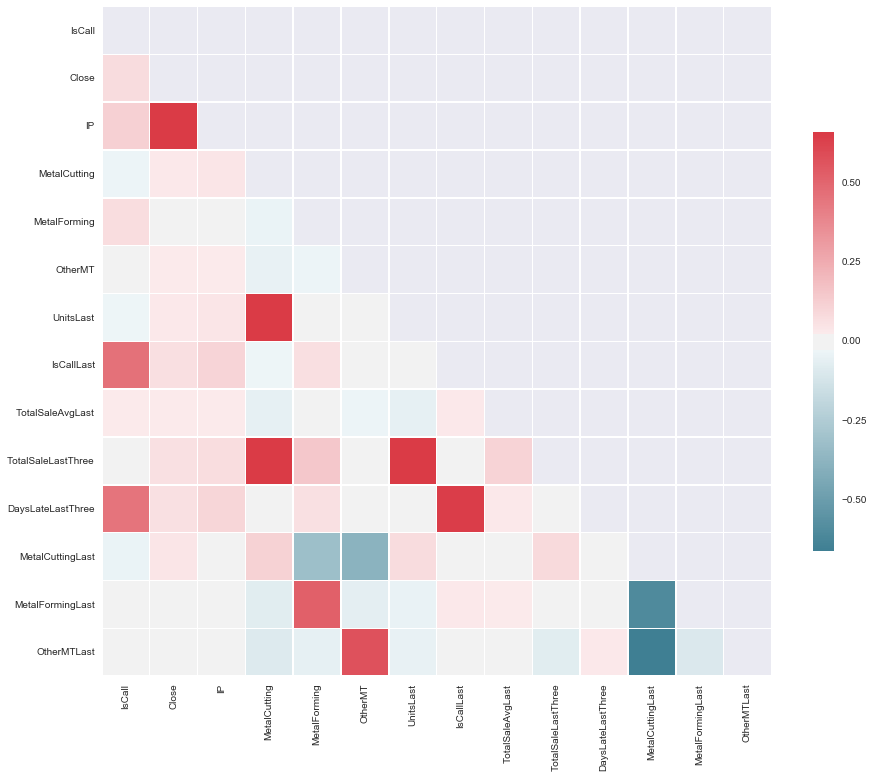

In [32]:
#Correlation Matrix Plot
import matplotlib.pyplot as plt

# Generate a mask for the upper triangle
mask = np.zeros_like(corr2, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(15,15))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr2, mask=mask, cmap=cmap, vmax=.3,
            square=True, xticklabels=True, yticklabels=True,
            linewidths=.5, cbar_kws={"shrink": .5}, ax=ax)


In [33]:
PAIRPLOT2.describe()

,IsCall,Close,IP,MetalCutting,MetalForming,OtherMT,UnitsLast,IsCallLast,TotalSaleAvgLast,TotalSaleLastThree,DaysLateLastThree,MetalCuttingLast,MetalFormingLast,OtherMTLast
count,16040.000000,16040.000000,16040.000000,16040.000000,16040.000000,16040.000000,16040.000000,16040.000000,1.604000e+04,1.604000e+04,16040.000000,16040.000000,16040.000000,16040.000000
mean,0.231858,1388.674964,99.706184,21.385786,1.026185,1.263092,22.592706,0.225499,2.327278e+05,3.403679e+06,3.253616,0.789952,0.086804,0.105601
std,0.422032,295.474676,4.945777,87.561245,5.830594,5.778330,83.979435,0.417923,4.163287e+05,7.625688e+06,10.696906,0.386860,0.266157,0.287914
min,0.000000,735.090027,87.412500,0.000000,0.000000,0.000000,-7.000000,0.000000,-2.639510e+06,-2.828082e+06,-36.333333,0.000000,0.000000,0.000000
25%,0.000000,1186.689941,96.495900,2.000000,0.000000,0.000000,3.000000,0.000000,7.265131e+04,5.162025e+05,-3.666667,0.875000,0.000000,0.000000
50%,0.000000,1365.680054,101.038200,6.000000,0.000000,0.000000,8.000000,0.000000,1.377012e+05,1.314886e+06,0.000000,1.000000,0.000000,0.000000
75%,0.000000,1526.750000,103.526300,17.000000,0.000000,0.000000,19.000000,0.000000,2.596626e+05,3.110017e+06,7.333333,1.000000,0.000000,0.000000
max,1.000000,2067.560059,106.686800,1867.000000,157.000000,130.000000,1867.000000,1.000000,1.700000e+07,9.903093e+07,77.666667,1.000000,1.000000,1.000000


In [34]:
# Feature Importance with Extra Trees Classifier

from sklearn.ensemble import ExtraTreesClassifier
array = PAIRPLOT2.values
X = array[:,1:14]
Y = array[:,0]

# feature extraction

model = ExtraTreesClassifier()
model.fit(X, Y)
print(model.feature_importances_)

[ 0.08092498  0.08351508  0.08676024  0.02218225  0.02246998  0.09386858
  0.17701225  0.10255185  0.09571498  0.18756811  0.01806232  0.01430867
  0.0150607 ]


In [35]:
# Feature Extraction with RFE 

from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression

# load data

array = PAIRPLOT2.values
X = array[:,1:14]
Y = array[:,0]
# feature extraction
model = LogisticRegression()
rfe = RFE(model, 4)
fit = rfe.fit(X, Y)
print("Num Features: " , fit.n_features_)
print("Selected Features: " , fit.support_)
print("Feature Ranking: " , fit.ranking_)

Num Features:  4
Selected Features:  [False False False False False False  True False False False  True  True
  True]
Feature Ranking:  [ 7  3  6  4  5  8  1  9 10  2  1  1  1]


In [36]:
#Feature Extraction with PCA - in progress

from sklearn.decomposition import PCA
array = PAIRPLOT2.values
X = array[:,1:14]
Y = array[:,0]
# feature extraction
pca = PCA(n_components=4)
fit = pca.fit(X)
# summarize components
print("Explained Variance: ", fit.explained_variance_ratio_)
print(fit.components_)

Explained Variance:  [  9.97065801e-01   2.93419778e-03   1.48980310e-09   9.32685136e-11]
[[  2.59768820e-06   4.95716286e-08   8.63826194e-06   1.15558257e-07
   -1.08064639e-10   8.57979610e-06  -1.75938007e-10   6.15156581e-03
    9.99981079e-01   2.65281379e-08   4.37103843e-09  -5.83327097e-10
   -2.75457500e-09]
 [ -1.51500671e-05  -2.63256633e-07   2.94562830e-05   5.04680554e-08
    4.85963172e-07   2.88947832e-05  -3.33384075e-08  -9.99981078e-01
    6.15156534e-03  -7.83373086e-07   2.31111542e-09  -2.05794878e-08
   -3.56723479e-09]
 [ -9.99893296e-01  -1.31890394e-02   4.18957485e-03   6.13647086e-04
   -5.72097618e-04   3.96270370e-03  -9.67897487e-05   1.54066808e-05
    2.43313713e-06  -2.33943959e-03  -4.79096755e-05   2.20839278e-05
    9.64671393e-06]
 [  5.76971639e-03   3.92888317e-05   7.44385824e-01  -1.68508642e-02
   -3.78560356e-03   6.67473949e-01  -1.64905127e-04   4.10523458e-05
   -1.24226458e-05  -6.04246013e-03   2.92841820e-04  -2.59516058e-04
   -7.434

In [37]:
#we end up using all features

In [62]:
#test different types of models

array = PAIRPLOT2.values
X = array[:,1:14].astype(float)
Y = array[:,0]
validation_size = 0.33
seed = 7
X_train, X_validation, Y_train, Y_validation = cross_validation.train_test_split(X, Y,
test_size=validation_size, random_state=seed)
num_folds = 5
num_instances = len(X_train)
seed = 7
scoring = 'accuracy'
models = []
models.append(('LR', LogisticRegression()))
models.append(('LDA', LinearDiscriminantAnalysis()))
models.append(('KNN', KNeighborsClassifier()))
models.append(('KNNWeighted', KNeighborsClassifier(weights='distance')))
models.append(('CART', DecisionTreeClassifier()))
models.append(('NB', GaussianNB()))
#models.append(('SVM', SVC())) - causes code to hang
results = []
names = []
for name, model in models:
    kfold = cross_validation.KFold(n=num_instances, n_folds=num_folds, random_state=seed)
    cv_results = cross_validation.cross_val_score(model, X_train, Y_train, cv=kfold, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    msg = (name, cv_results.mean(),cv_results.std())
    print(msg)


('LR', 0.77033311329228304, 0.0049488182208948638)
('LDA', 0.81155708983085684, 0.0059802620837425243)
('KNN', 0.73664549222461506, 0.0059672943338631391)
('KNNWeighted', 0.71273029099527085, 0.0050697586521770074)
('CART', 0.75842081227612623, 0.0080454503941889532)
('NB', 0.76679654138755726, 0.0038768247518050233)


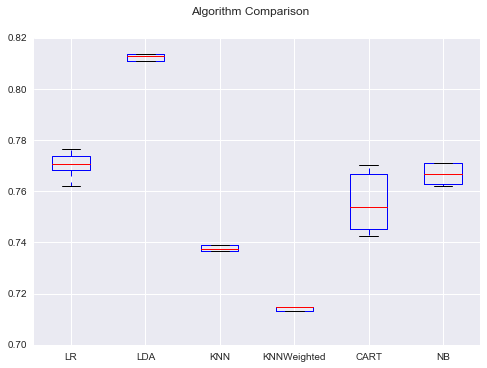

In [39]:
#distribution of models, accuracy and std dev

fig = plt.figure()
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()

In [40]:
PAIRPLOT2.head()

,IsCall,Close,IP,MetalCutting,MetalForming,OtherMT,UnitsLast,IsCallLast,TotalSaleAvgLast,TotalSaleLastThree,DaysLateLastThree,MetalCuttingLast,MetalFormingLast,OtherMTLast
0,0,1270.089966,102.1531,0,0,7,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0
1,0,1270.199951,102.5220,0,0,2,7.0,0.0,131438.714286,0.000000,0.000000,0.0,0.0,1.0
2,0,1276.660034,102.5057,0,0,11,2.0,0.0,153945.500000,0.000000,0.000000,0.0,0.0,1.0
3,1,1303.819946,102.8357,0,0,1,11.0,0.0,57971.090909,621881.333333,-4.000000,0.0,0.0,1.0
4,0,1377.939941,102.6297,0,0,1,1.0,1.0,65994.000000,337189.000000,2.666667,0.0,0.0,1.0


In [41]:
a = pd.DataFrame({'a':X[:,0],'b':X[:,1],'c':X[:,2],'d':X[:,3],'e':X[:,4],'f':X[:,5],'g':X[:,6]}).head()

print (a.columns)
print (PAIRPLOT2.columns)

Index(['a', 'b', 'c', 'd', 'e', 'f', 'g'], dtype='object')
Index(['IsCall', 'Close', 'IP', 'MetalCutting', 'MetalForming', 'OtherMT',
       'UnitsLast', 'IsCallLast', 'TotalSaleAvgLast', 'TotalSaleLastThree',
       'DaysLateLastThree', 'MetalCuttingLast', 'MetalFormingLast',
       'OtherMTLast'],
      dtype='object')


In [42]:
#exports decision tree for viewing - we see that it's massive and indicates overfitting

#>>> from sklearn import tree
#>>>
#>>> clf = tree.DecisionTreeClassifier()
#>>> clf = clf.fit(X_train, Y_train)
#>>> tree.export_graphviz(clf,
#...     out_file='usmto3.dot',feature_names = a.columns)   

In [43]:
#>>> from sklearn.externals.six import StringIO
#>>> with open("usmto3.dot", 'w') as f:
#...     f = tree.export_graphviz(clf, out_file=f)

#>>> import os
#>>> os.unlink('usmto3.dot')

In [44]:
#classification report with kNN

from sklearn.metrics import classification_report

array = PAIRPLOT2.values
X = array[:,1:14]
Y = array[:,0]
test_size = 0.33
seed = 7
X_train, X_test, Y_train, Y_test = cross_validation.train_test_split(X, Y,
test_size=test_size, random_state=seed)
model = KNeighborsClassifier()
model.fit(X_train, Y_train)
predicted = model.predict(X_test)
report = classification_report(Y_test, predicted)
print(report)

             precision    recall  f1-score   support

        0.0       0.77      0.91      0.84      4043
        1.0       0.31      0.12      0.17      1251

avg / total       0.66      0.73      0.68      5294



In [45]:
#classification report with CART

from sklearn.metrics import classification_report

array = PAIRPLOT2.values
X = array[:,1:14]
Y = array[:,0]
test_size = 0.33
seed = 7
X_train, X_test, Y_train, Y_test = cross_validation.train_test_split(X, Y,
test_size=test_size, random_state=seed)
model = DecisionTreeClassifier()
model.fit(X_train, Y_train)
predicted = model.predict(X_test)
report = classification_report(Y_test, predicted)
print(report)

             precision    recall  f1-score   support

        0.0       0.84      0.84      0.84      4043
        1.0       0.49      0.50      0.49      1251

avg / total       0.76      0.76      0.76      5294



In [46]:
array = PAIRPLOT2.values
X = array[:,1:14]
Y = array[:,0]
test_size = 0.33
seed = 7
X_train, X_test, Y_train, Y_test = cross_validation.train_test_split(X, Y,
test_size=test_size, random_state=seed)
model = LogisticRegression()
model.fit(X_train, Y_train)
predicted = model.predict(X_test)
report = classification_report(Y_test, predicted)
print(report)

             precision    recall  f1-score   support

        0.0       0.76      1.00      0.87      4043
        1.0       1.00      0.00      0.00      1251

avg / total       0.82      0.76      0.66      5294



In [47]:
array = PAIRPLOT2.values
X = array[:,1:14]
Y = array[:,0]
test_size = 0.33
seed = 7
X_train, X_test, Y_train, Y_test = cross_validation.train_test_split(X, Y,
test_size=test_size, random_state=seed)
model = LinearDiscriminantAnalysis()
model.fit(X_train, Y_train)
predicted = model.predict(X_test)
report = classification_report(Y_test, predicted)
print(report)

             precision    recall  f1-score   support

        0.0       0.87      0.88      0.88      4043
        1.0       0.60      0.57      0.58      1251

avg / total       0.81      0.81      0.81      5294



In [48]:
array = PAIRPLOT2.values
X = array[:,1:14]
Y = array[:,0]
test_size = 0.33
seed = 7
X_train, X_test, Y_train, Y_test = cross_validation.train_test_split(X, Y,
test_size=test_size, random_state=seed)
model = GaussianNB()
model.fit(X_train, Y_train)
predicted = model.predict(X_test)
report = classification_report(Y_test, predicted)
print(report)

             precision    recall  f1-score   support

        0.0       0.76      0.99      0.86      4043
        1.0       0.26      0.01      0.03      1251

avg / total       0.65      0.76      0.66      5294



In [49]:
# Cross Validation Classification LogLoss (smaller logloss better with 0 as perfect logloss)


from sklearn import cross_validation
array = PAIRPLOT2.values
X = array[:,1:14]
Y = array[:,0]
num_folds = 10
num_instances = len(X)
seed = 7
kfold = cross_validation.KFold(n=num_instances, n_folds=num_folds, random_state=seed)
model = LinearDiscriminantAnalysis()
scoring = 'log_loss'
results = cross_validation.cross_val_score(model, X, Y, cv=kfold, scoring = scoring)
print("Logloss: ", results.mean(), "      Std Dev: ", results.std()*100.0)

Logloss:  -0.433025278378       Std Dev:  6.56241887058


In [50]:
# ROC 

from sklearn import cross_validation
array = PAIRPLOT2.values
X = array[:,1:14]
Y = array[:,0]
num_folds = 10
num_instances = len(X)
seed = 7
kfold = cross_validation.KFold(n=num_instances, n_folds=num_folds, random_state=seed)
model = LinearDiscriminantAnalysis()
scoring = 'roc_auc'
results = cross_validation.cross_val_score(model, X, Y, cv=kfold, scoring = scoring)
print("AUC: ", results.mean(), "      Std Dev: ", results.std()*100.0)


AUC:  0.829599696758       Std Dev:  2.11779701723


In [51]:
np.random.uniform(0,1,len(PAIRPLOT2)) <= .3

array([ True, False, False, ..., False, False, False], dtype=bool)

In [52]:
PAIRPLOT2.columns

Index(['IsCall', 'Close', 'IP', 'MetalCutting', 'MetalForming', 'OtherMT',
       'UnitsLast', 'IsCallLast', 'TotalSaleAvgLast', 'TotalSaleLastThree',
       'DaysLateLastThree', 'MetalCuttingLast', 'MetalFormingLast',
       'OtherMTLast'],
      dtype='object')

Neighbors: 1, Accuracy: 0.660474
Neighbors: 3, Accuracy: 0.704264
Neighbors: 5, Accuracy: 0.729919
Neighbors: 7, Accuracy: 0.746461
Neighbors: 9, Accuracy: 0.753008
Neighbors: 11, Accuracy: 0.757254
Neighbors: 13, Accuracy: 0.759289
Neighbors: 15, Accuracy: 0.763447
Neighbors: 17, Accuracy: 0.766366
Neighbors: 19, Accuracy: 0.767604
Neighbors: 21, Accuracy: 0.767604
Neighbors: 23, Accuracy: 0.767427
Neighbors: 25, Accuracy: 0.767781
Neighbors: 27, Accuracy: 0.768577
Neighbors: 29, Accuracy: 0.768489
Neighbors: 31, Accuracy: 0.768931
Neighbors: 33, Accuracy: 0.769374
Neighbors: 35, Accuracy: 0.769728
Neighbors: 37, Accuracy: 0.769462
Neighbors: 39, Accuracy: 0.769374
Neighbors: 41, Accuracy: 0.769462
Neighbors: 43, Accuracy: 0.769551
Neighbors: 45, Accuracy: 0.769462
Neighbors: 47, Accuracy: 0.769462
Neighbors: 49, Accuracy: 0.769108


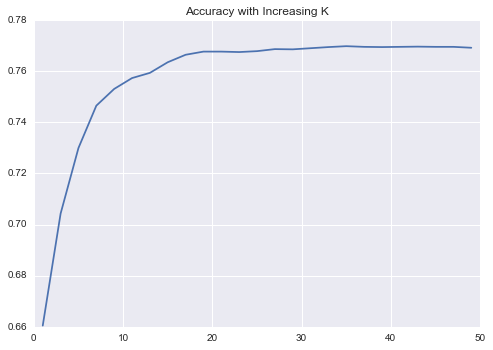

In [53]:
#select optimal K

from sklearn.neighbors import KNeighborsClassifier

df = PAIRPLOT2

test_idx = np.random.uniform(0, 1, len(df)) <= 0.3
train = df[test_idx==True]
test = df[test_idx==False]

features = ['Close', 'IP', 'MetalCutting', 'MetalForming', 'OtherMT',
       'UnitsLast', 'IsCallLast', 'TotalSaleAvgLast', 'TotalSaleLastThree',
       'DaysLateLastThree', 'MetalCuttingLast', 'MetalFormingLast',
       'OtherMTLast']

results = []
for n in range(1, 51, 2):
    clf = KNeighborsClassifier(n_neighbors=n)
    clf.fit(train[features], train['IsCall'])
    preds = clf.predict(test[features])
    accuracy = np.where(preds==test['IsCall'], 1, 0).sum() / float(len(test))
    print ("Neighbors: %d, Accuracy: %3f" % (n, accuracy))

    results.append([n, accuracy])

results = pd.DataFrame(results, columns=["n", "accuracy"])

plt.plot(results.n, results.accuracy)
plt.title("Accuracy with Increasing K")
plt.show()

In [55]:
Y.data.shape

(16040,)

In [56]:
Y_validation.shape

(5294,)

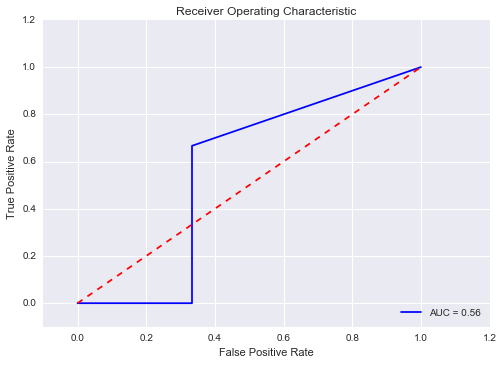

In [57]:
#plot ROC
from sklearn.metrics import roc_curve, auc

actual = [1,1,1,0,0,0]
predictions = [0.5,0.6,0.7,0.8,0.5,0.5]

false_positive_rate, true_positive_rate, thresholds = roc_curve(actual, predictions)
roc_auc = auc(false_positive_rate, true_positive_rate)

plt.title('Receiver Operating Characteristic')
plt.plot(false_positive_rate, true_positive_rate, 'b',
label='AUC = %0.2f'% roc_auc)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.1,1.2])
plt.ylim([-0.1,1.2])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [58]:
#rescales all data to be between 0 and 1 and readies it for further processing to make it more fitting for kNN - next step
import scipy

from sklearn.preprocessing import MinMaxScaler

array = PAIRPLOT2.values
# separate array into input and output components
X = array[:,1:14]
Y = array[:,0]
scaler = MinMaxScaler(feature_range=(0, 1))
rescaledX = scaler.fit_transform(X)

#rescaledX3 = rescaledX.reshape((-1,8))

#rescaledX3 = pd.DataFrame({'IsCall':rescaledX[:,0],'Close':rescaledX[:,1],'Three_MMA_Late':rescaledX[:,2],'Three_MMA_SalesTrend':rescaledX[:,3],'DaysLateLastThree':rescaledX[:,4],'TotalSaleLastThree':rescaledX[:,5],'DaysLateLast':rescaledX[:,6],'UnitsLast':rescaledX[:,7],'IsCallLast':rescaledX[:,8]})
#sns.boxplot(data = rescaledX3, orient = 'h', fliersize = '.5')

In [59]:
#creates three dummy variables from each feature, to reduce overfitting in decision tree

In [60]:
y = PAIRPLOT2['Close']
X = PAIRPLOT2['IsCall']
dt = DecisionTreeClassifier(min_samples_split=20, random_state=99)
dt.fit(X, y)

C:\Users\lzhang\AppData\Local\Continuum\Anaconda3\lib\site-packages\sklearn\utils\validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)


ValueError: Unknown label type: array([[ 1270.089966],
       [ 1270.199951],
       [ 1276.660034],
       ..., 
       [ 2018.050049],
       [ 2067.560059],
       [ 2058.899902]])

In [ ]:
********BREAK**********

In [ ]:
from sklearn import svm, datasets
from sklearn.metrics import roc_curve, auc
from sklearn.cross_validation import train_test_split
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from scipy import interp


In [ ]:
# Import some data to play with
array = PAIRPLOT2.values
X = array[:,1:14]
y = array[:,0]

# Binarize the output
y = label_binarize(y, classes=[0, 1])
n_classes = y.shape[1]

# Add noisy features to make the problem harder
random_state = np.random.RandomState(0)
n_samples, n_features = X.shape
X = np.c_[X, random_state.randn(n_samples, 200 * n_features)]

# shuffle and split training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.5,
                                                    random_state=0)

# Learn to predict each class against the other
classifier = OneVsRestClassifier(svm.SVC(kernel='linear', probability=True,
                                 random_state=random_state))
y_score = classifier.fit(X_train, y_train).decision_function(X_test)


In [ ]:
predicted.shape

In [ ]:
Y_test.shape

In [ ]:
Y_train.shape

In [ ]:
Y_validation.shape

In [ ]:
X_test.shape

In [ ]:
X_train.shape

In [ ]:
n_classes

In [ ]:
predicted.tofile('predicted.xls',sep = ",")

In [ ]:
Y_test.tofile('ytest.xls',sep = ",")

In [ ]:
Y_validation.tofile('validation.xls',sep = ',')

In [ ]:
roc_curve?

In [ ]:

# Compute ROC curve and ROC area for each class
array = PAIRPLOT2.values
X = array[:,1:14]
Y = array[:,0]

n_classes = Y.shape[0]

fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(predicted.shape[0]):
    fpr[i], tpr[i] = roc_curve(Y_test[:, i], predicted[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

plt.figure()
plt.plot(fpr[2], tpr[2], label='ROC curve (area = %0.2f)' % roc_auc[2])
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

In [ ]:
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
plt.figure()
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         linewidth=2)

plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         linewidth=2)

for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label='ROC curve of class {0} (area = {1:0.2f})'
                                   ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Some extension of Receiver operating characteristic to multi-class')
plt.legend(loc="lower right")
plt.show()